In [1]:
import numpy as np
import keras
import pandas as pd 
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM,Bidirectional,GlobalMaxPooling1D
import re
import tensorflow as tf
from keras.preprocessing.text import Tokenizer

In [2]:
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Activation, Conv2D, Input, Embedding, Reshape, MaxPool1D, Concatenate, Flatten, Dropout, Dense, Conv1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam,SGD
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns

In [3]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/6-class-bert-preprocessed-dataset/Bert_Preprocessed_Dataset.xlsx


In [4]:
pip install openpyxl

Note: you may need to restart the kernel to use updated packages.


In [6]:
df=pd.read_excel('/kaggle/input/6-class-bert-preprocessed-dataset/Bert_Preprocessed_Dataset.xlsx')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6405 entries, 0 to 6404
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  6405 non-null   int64 
 1   ID          6404 non-null   object
 2   Text        6404 non-null   object
 3   Sentiment   6405 non-null   object
 4   Label       6405 non-null   int64 
 5   Token       6405 non-null   object
 6   Token_ID    6405 non-null   object
dtypes: int64(2), object(5)
memory usage: 350.4+ KB


In [7]:
df.head()

,Unnamed: 0,ID,Text,Sentiment,Label,Token,Token_ID
0,479,939195189512152_939206382844366,উনারে লাথথায়ে মিরপুর চিড়িয়াখানার প্রধান সিকিউর...,angry,0,"['উনার', '##ে', 'লা', '##থ', '##থা', '##যে', '...","[36081, 2094, 3853, 7740, 12969, 8844, 15638, ..."
1,1750,935156429916028_935165096581828,কই এখন আপনি লেকচার থেমে গেল কেন ভাই,angry,0,"['কই', 'এখন', 'আপনি', 'লেকচার', 'থেমে', 'গেল',...","[6852, 2112, 2536, 22174, 3214, 2590, 2304, 2570]"
2,1855,987743164678331_1529633654011820,সুন্দর জোক্স,happy,3,"['সনদ', '##র', 'জে', '##াক', '##স']","[5391, 2046, 4803, 15547, 2388]"
3,1382,935324716565866_935576566540681,বেশির ভাগ ক্ষেত্রে যাত্রী গন কম ভুল করে আর বেশ...,sad,4,"['বেশির', 'ভাগ', 'কষে', '##তর', '##ে', 'যা', '...","[3217, 2516, 19675, 12499, 2094, 2120, 42396, ..."
4,3388,987743164678331_552808888211836,বাংলাদেশের হিন্দু মুসলিম সবাই ভাই ভাই যে অন্যন...,sad,4,"['বাংলাদেশের', 'হিন', '##দ', 'মস', '##লিম', 'স...","[2119, 50082, 5718, 23143, 33783, 2553, 2570, ..."


<AxesSubplot:xlabel='Label', ylabel='count'>

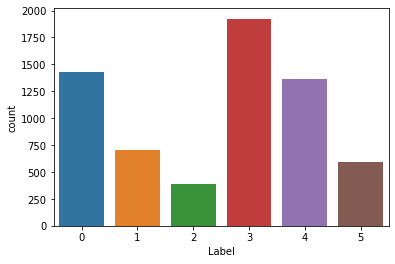

In [8]:
sns.countplot(df['Label'])

In [9]:
df.Label.value_counts(), len(df)

(3    1924
 0    1427
 4    1366
 1     704
 5     592
 2     392
 Name: Label, dtype: int64,
 6405)

In [10]:
maxlen = 300
max_features = 10000
batch_size = 32

In [11]:
df['Token']=df['Token'].astype('str')

In [12]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df['Token'],df['Label'] , test_size=0.1,random_state=2)
x_train, x_validation, y_train, y_validation = train_test_split(x_train,y_train,test_size=0.1,random_state=42)

In [13]:
vocab_size=32000

In [14]:
tokenizer  = Tokenizer(num_words = max_features,oov_token = "<OOV>")
tokenizer.fit_on_texts(df['Token'])

train_seq =  tokenizer.texts_to_sequences(x_train)
val_seq =  tokenizer.texts_to_sequences(x_validation)
test_seq = tokenizer.texts_to_sequences(x_test)

In [15]:
x_train = pad_sequences(train_seq, maxlen=maxlen, dtype='int32', padding='post',truncating='post') #maxlen = maxlen, padding='post')
x_validation = pad_sequences(val_seq, maxlen=maxlen, dtype='int32', padding='post',truncating='post') #maxlen = maxlen, padding='post')
x_test = pad_sequences(test_seq, maxlen=maxlen, dtype='int32', padding='post',truncating='post') #maxlen = maxlen, padding='post')

In [21]:
model= Sequential()
model.add(Embedding(vocab_size,100,input_length=maxlen,name='Embedding'))
model.add(Conv1D(200, kernel_size=3, activation = "relu"))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.25))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(25, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(12, activation='relu'))
model.add(Flatten())
model.add(Dense(units=6, activation='softmax'))
adam=Adam(learning_rate=0.003)
model.summary()
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Embedding (Embedding)        (None, 300, 100)          3200000   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 298, 200)          60200     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 200)               0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 100)               20100     
_________________________________________________________________
dropout_5 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 50)               

In [22]:
early_stopping = keras.callbacks.EarlyStopping(
    patience=15,
    min_delta=0.001,
    restore_best_weights=True,
)

In [23]:
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=30, callbacks=[early_stopping],verbose=1, validation_data=(x_validation, y_validation))

Epoch 1/30
163/163 [==============================] - 15s 84ms/step - loss: 1.6318 - accuracy: 0.3004 - val_loss: 1.5272 - val_accuracy: 0.3865
Epoch 2/30
163/163 [==============================] - 13s 82ms/step - loss: 1.4357 - accuracy: 0.4097 - val_loss: 1.4738 - val_accuracy: 0.4333
Epoch 3/30
163/163 [==============================] - 14s 86ms/step - loss: 1.2583 - accuracy: 0.4883 - val_loss: 1.4772 - val_accuracy: 0.4506
Epoch 4/30
163/163 [==============================] - 13s 82ms/step - loss: 1.0905 - accuracy: 0.5489 - val_loss: 1.5917 - val_accuracy: 0.4662
Epoch 5/30
163/163 [==============================] - 14s 86ms/step - loss: 0.9226 - accuracy: 0.6175 - val_loss: 1.9037 - val_accuracy: 0.4229
Epoch 6/30
163/163 [==============================] - 13s 82ms/step - loss: 0.8332 - accuracy: 0.6696 - val_loss: 1.8503 - val_accuracy: 0.3917
Epoch 7/30
163/163 [==============================] - 14s 85ms/step - loss: 0.7202 - accuracy: 0.7154 - val_loss: 2.2277 - val_accuracy:

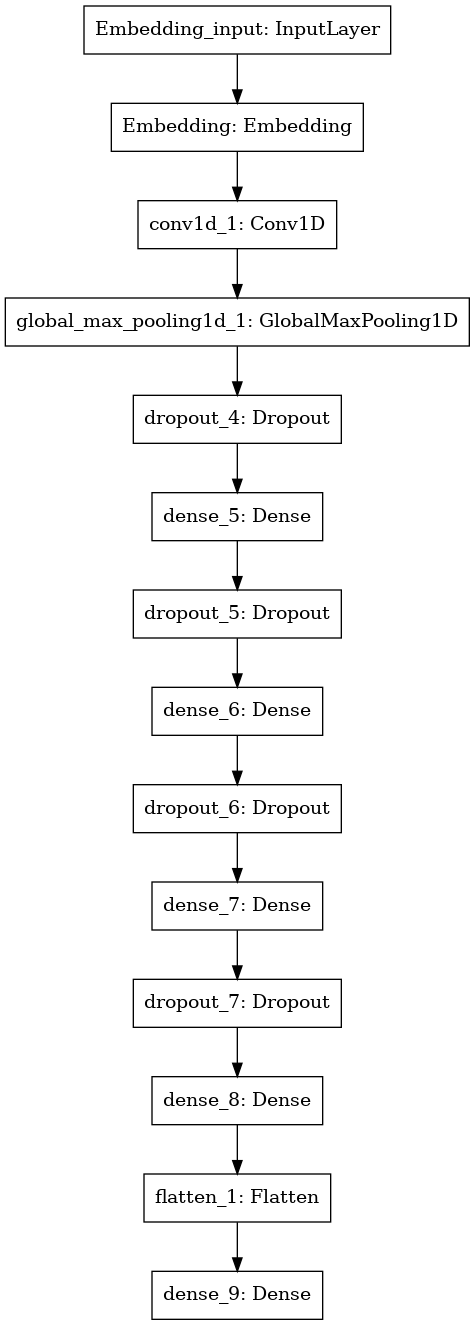

In [24]:
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=False,show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96)

In [25]:
model.evaluate(x_test, y_test)

21/21 [==============================] - 0s 14ms/step - loss: 1.4223 - accuracy: 0.4524


[1.4223144054412842, 0.45241808891296387]

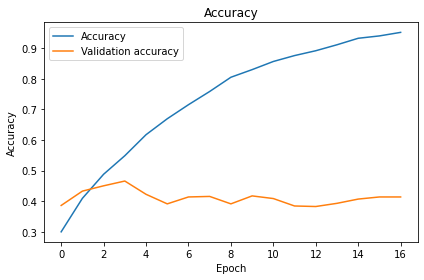

In [26]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label="Accuracy")
plt.plot(history.history['val_accuracy'], label="Validation accuracy")
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.savefig('6 classes CNN Val_acc.png',format='png',transparent='True')
plt.show()


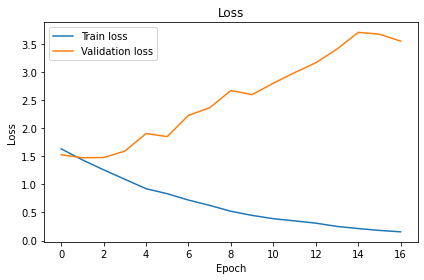

In [27]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label="Train loss")
plt.plot(history.history['val_loss'], label="Validation loss")
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.savefig('6 classes CNN Val_loss.png',format='png',transparent='True')
plt.show()

In [28]:
from sklearn.metrics import classification_report

y_pred_raw = model.predict(x_test)
y_pred = np.argmax(y_pred_raw,axis=1)

In [29]:
print(y_test.shape)
print(y_pred.shape)

(641,)
(641,)


In [30]:
y_pred = y_pred.reshape(-1,1)


In [31]:
categories = ['0','1','2','3','4','5']
print(classification_report(y_test, y_pred, target_names=categories))

              precision    recall  f1-score   support

           0       0.35      0.82      0.49       154
           1       0.00      0.00      0.00        79
           2       0.00      0.00      0.00        42
           3       0.59      0.83      0.69       193
           4       0.44      0.03      0.06       123
           5       0.00      0.00      0.00        50

    accuracy                           0.45       641
   macro avg       0.23      0.28      0.21       641
weighted avg       0.35      0.45      0.34       641



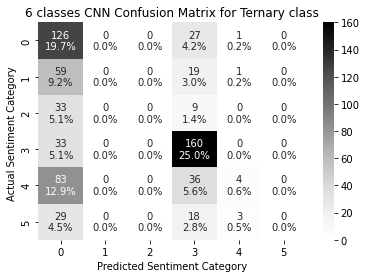

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(y_test, y_pred)
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]

group_percentages = ["{0:.1%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_counts,group_percentages)]

labels = np.asarray(labels).reshape(6,6)

ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Greys')

ax.set_title('6 classes CNN Confusion Matrix for Ternary class');
ax.set_xlabel('Predicted Sentiment Category')
ax.set_ylabel('Actual Sentiment Category ');

ax.xaxis.set_ticklabels(['0','1','2','3','4','5'])
ax.yaxis.set_ticklabels(['0','1','2','3','4','5'])
sns.set(color_codes=True)
sns.set(font_scale=.8)
plt.savefig('6 classes CNN Confusion Matrix for Ternary class.png', bbox_inches = "tight")
plt.show()

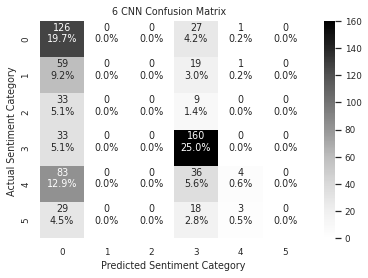

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(y_test, y_pred)
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]

group_percentages = ["{0:.1%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f"{v1}\n{v2}\n" for v1, v2 in
          zip(group_counts,group_percentages)]

labels = np.asarray(labels).reshape(6,6)

ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Greys')

ax.set_title('6 CNN Confusion Matrix   ');
ax.set_xlabel('Predicted Sentiment Category')
ax.set_ylabel('Actual Sentiment Category ');

ax.xaxis.set_ticklabels(['0','1','2','3','4','5'])
ax.yaxis.set_ticklabels(['0','1','2','3','4','5'])
sns.set(color_codes=True)
sns.set(font_scale=.8)
plt.savefig('6 classes CNN Confusion Matrix.png', bbox_inches = "tight")
plt.show()

Accuracy: 0.45
Auc: 0.7
Detail:
              precision    recall  f1-score   support

           0       0.35      0.82      0.49       154
           1       0.00      0.00      0.00        79
           2       0.00      0.00      0.00        42
           3       0.59      0.83      0.69       193
           4       0.44      0.03      0.06       123
           5       0.00      0.00      0.00        50

    accuracy                           0.45       641
   macro avg       0.23      0.28      0.21       641
weighted avg       0.35      0.45      0.34       641



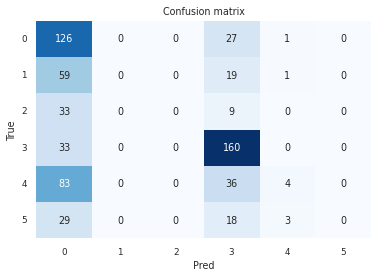

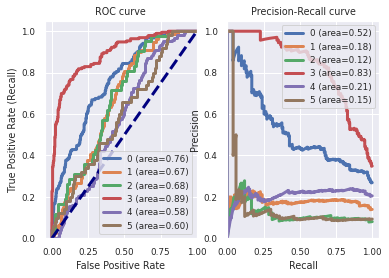

In [35]:
#!pip install metrics
import sklearn.metrics as metrics
classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values
    
## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test, y_pred)
auc = metrics.roc_auc_score(y_test, y_pred_raw, 
                            multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_test, y_pred))
    
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

fig, ax = plt.subplots(nrows=1, ncols=2)
## Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           y_pred_raw[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="ROC curve")
ax[0].legend(loc="lower right")
ax[0].grid(True)
plt.savefig('6 classes CNN ROC.png', bbox_inches = "tight")
    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], y_pred_raw[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.savefig('6 classes CNN precision-recall curve.png', bbox_inches = "tight")
plt.show()
